# Downloading dataset and other content for libraries

In [1]:
from os import listdir
from os import path

ds_path = '/content/dataset/'

if not path.exists(ds_path):
  COMPUTE_DATASET = True

else:
  files = listdir(ds_path)
  last = len(files)

  COMPUTE_DATASET = last < 100

In [2]:
if COMPUTE_DATASET:
  ! git clone https://github.com/Luca1920342/NN_project.git
  ! cp -R NN_project/* /content
  ! rm -rf NN_project
else:
  print("Dataset is already computed, I skip some downloads")

Dataset is already computed, I skip some downloads


In [3]:
! pip install dotmap -q

In [4]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

import torchaudio

from torchsummary import summary

from dotmap import DotMap

# Getting functions to perform CQTransform from the source document
from src.CQT_nsgt import CQT_cpx

# Defining the model's blocks

Encoder for the noise - RFF stands for Randm Fourier Frequencies

It transforms the sigma vector of size batch_size in a tensor of shape batch_size x 64

In [5]:
class RFF_encoder(nn.Module):
  # Encodes input variance with Random Fourier Features

  def __init__(self):
    super().__init__()

    self.freq = nn.Parameter(16 * torch.randn([1, 32]), requires_grad=False)

  def forward(self, sigma):
    # Build a table for each value of sigma (rows)
    # and 64 columns (first 32 for sines, last 32 for cosines)

    col = sigma * 2 * np.pi * self.freq # Angular frequency is a random value multiplied by sigma

    return torch.cat([torch.sin(col), torch.cos(col)], dim=1)

Multi Layer Perceptron to embed the noise in a batch_size x 512 tensor

In [6]:
class MultiLayerPerceptron(nn.Module):
  # Embeds the sigma resulting from the RFF module

  def __init__(self):
    super().__init__()

    self.layers = [
            nn.Linear(64, 128),
            nn.Linear(128, 256),
            nn.Linear(256, 512)
        ]
    
  def forward(self, sigma):
    # An input with 64 features is returned
    # as an output with 512 features

    for lay in self.layers:
      sigma = F.relu(lay(sigma.cpu())).to(device) # For some reason I have to move the sigma to the cpu

    return sigma

It isn't really clear what this module does, I copied it from the source code

Anyway, it's purpose is to embed frequencies in the input

In [62]:
class AddFreqEncodingRFF(nn.Module):
    '''
    [B, T, F, 2] => [B, T, F, 12]  
    Generates frequency positional embeddings and concatenates them as 10 extra channels
    This function is optimized for F=1025
    '''
    def __init__(self, f_dim, N):
        super().__init__()
        
        self.N = N
        
        # First, does a RFF encoding (as RFF_encoder)
        self.RFF_freq = nn.Parameter(16 * torch.randn([1, N]), requires_grad=False)

        self.f_dim=f_dim #f_dim is fixed
        embeddings=self.build_RFF_embedding()

        # And uses it as a parameter
        self.embeddings=nn.Parameter(embeddings, requires_grad=False) 

    def build_RFF_embedding(self):
        """
        Returns:
          table:
              (shape: [C,F], dtype: float32)
        """
        freqs = self.RFF_freq
        #freqs = freqs.to(device=torch.device("cuda"))
        freqs=freqs.unsqueeze(-1) # [1, 32, 1]

        self.n=torch.arange(start=0, end=self.f_dim)
        self.n=self.n.unsqueeze(0).unsqueeze(0)  #[1,1,F]

        table = 2 * np.pi * self.n * freqs

        #print(freqs.shape, x.shape, table.shape)
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1) #[1,32,F]

        return table
    

    def forward(self, input_tensor):

        batch_size_tensor = input_tensor.shape[0]  # get batch size
        time_dim = input_tensor.shape[-1]  # get time dimension

        fembeddings_2 = torch.broadcast_to(self.embeddings, [batch_size_tensor, time_dim,self.N*2, self.f_dim])
        fembeddings_2=fembeddings_2.permute(0,2,3,1)
    
        return torch.cat((input_tensor,fembeddings_2),1)  

FiLM modulation for sigma - linear transformation

In [8]:
class Film(nn.Module):
    def __init__(self, dim_out):
        super().__init__()

        self.output_layer = nn.Linear(512, dim_out)

    def forward(self, sigma_encoding):
        sigma_encoding = self.output_layer(sigma_encoding)
        sigma_encoding = sigma_encoding.unsqueeze(-1)
        sigma_encoding = sigma_encoding.unsqueeze(-1) # we need a second unsqueeze because our data is 2d [B,C,1,1]
        
        gamma = sigma_encoding

        return gamma

This RBlock (Residual Block) is sligthly different from the original code, I wrote it according to the paper.

In the source code is different in defining the convolutions.

In [63]:
class RBlock(nn.Module):
  # Applies convolutions on the input signal

  def __init__(self,
               dim_in, dim_out, depth = 8):
    super().__init__()

    self.film = Film(dim_in)

    # This is needed to reshape the input, preparing for the residual connection
    self.res_conv = nn.Conv2d(dim_in, dim_out, 1, padding_mode="reflect", bias=False) if dim_in != dim_out else nn.Identity()

    self.first_conv=nn.Sequential(nn.GELU(), nn.Conv2d(dim_in, dim_out, 1))

    self.body = nn.ModuleList()

    for i in range(depth):
      self.body.append(nn.ModuleList([
          nn.GELU(),
          nn.Conv2d(dim_out, dim_out, 
                    kernel_size= (5,3),
                    dilation=(2**i,1),
                    stride=1,
                    padding='same',
                    padding_mode='reflect')]))
      
  def forward(self, input, sigma):
    gamma = self.film(sigma)

    x = input * gamma

    y = self.first_conv(x)

    for modules in self.body:
      gelu, conv = modules
      y = y + conv(gelu(y))
      
    return self.res_conv(input) + y

Combiner block

In [10]:
class Combiner(nn.Module):
  def __init__(self, dim_in, dim_out):
    super().__init__()
    self.conv=nn.Conv2d(dim_in, dim_out, 1, bias=False)

  def forward(self, y, x):
    if x == None:
      return self.conv(y)

    y = self.conv(y)

    return y + x

This Block prepares the input of the RBlock.

In fact, it's possible to pass multiple inputs to the RBlock if they are concatenated together.

In [11]:
class CropConcatBlock(nn.Module):

    def forward(self, x, skip, **kwargs):
      # The size must be the one of x, skip could be smaller
      # This is due to downsampling and upsampling

      x1_width = x.shape[3]
      x2_width = skip.shape[3]

      if x1_width < x2_width: # skip is bigger than x, so I just crop skip
        skip = skip[:, :, :, 0:x1_width]
      elif x1_width > x2_width: # x is bigger than skip, so I have to enlarge skip with zeros
        s = skip.shape
        zeros = torch.zeros((s[0], s[1], s[2], x1_width - x2_width)).to(skip.device)
        skip = torch.cat((skip, zeros), 3)
      # else: I do nothing

      x = torch.cat((x, skip),1)
      
      return x

# Defining the model

In [12]:
class MainNet(nn.Module):
  def __init__(self, args, device):
    # In args are defined:
    #   sample_rate: audio sampling rate
    #   audio_len: audio length
    #   cqt.numocts: octaves covered by the transformation
    #   cqt.binsoct: number of bin for each octave
    #   depth: depth of en-decoder
    #   r_depth: depth of R blocks

    super().__init__()

    # Embedding of noise
    self.rff = RFF_encoder()
    self.mlp = MultiLayerPerceptron()

    # Constant-Q Transform
    fmax = args.sample_rate /2    # From the sampling theorem
    self.fmin = fmax/(2** args.cqt.numocts) # Given the octaves, get the lowest frequency available
    self.fbins = int(args.cqt.binsoct * args.cqt.numocts) # Total bins: bins/octave * octaves

    self.cqt=CQT_cpx(self.fmin, self.fbins, args.sample_rate, args.audio_len, device=device, split_0_nyq=False)

    # Frequency embedding
    self.f_dim = self.fbins +2
    N_freq_encoding = 32

    self.freq_encoding=AddFreqEncodingRFF(self.f_dim,N_freq_encoding)

    # Convolution
    Nin = N_freq_encoding*2 +2 # Number of features after the frequency embedding
    self.Ns= [32, 64, 64, 128, 128, 128, 128, 128]
               
    self.conv= nn.Conv2d(Nin, self.Ns[0], (5,3), padding="same", padding_mode="reflect", bias=False)

    self.depth = args.depth  # Depth of the encoder-decoder blocks

    self.encoBlock = nn.ModuleList()

    for i in range(self.depth):
      if i==0:
        dim_in=self.Ns[i]
        dim_out=self.Ns[i]
      else:
        dim_in=self.Ns[i-1]
        dim_out=self.Ns[i]

      if i < self.depth-1:
        self.encoBlock.append(nn.ModuleList([
            RBlock(dim_in, dim_out, depth = args.r_depth),
            torchaudio.transforms.Resample(2**12, 2**11), # I use 2**12 as an arbitrary number, as we don't care about the sampling frequency of the latents
            Combiner(2, dim_out)])) # I cannot use an obvious sum because shapes are different (2 != dim_out)
            
      elif i == self.depth-1: # no downsampling in the last layer
        self.encoBlock.append(nn.ModuleList([
            RBlock(dim_in, dim_out, depth = args.r_depth)]))
      
    self.midRBlocks = nn.ModuleList([
        RBlock(dim_out, dim_out, depth = args.r_depth),
        RBlock(dim_out, dim_out, depth = args.r_depth),
        RBlock(dim_out * 2, dim_out, depth = args.r_depth)]) # There's a skip cropping the doubles the dimension

    self.firstCombiner = Combiner(dim_out, 2)

    self.decoBlock = nn.ModuleList()

    for i in range(self.depth-1,-1,-1): # Reverse for for easier reading

      if i==0:
          dim_in=self.Ns[i]*2 # The doubling comes from the skip cropping
          dim_out=self.Ns[i]
      else:
          dim_in=self.Ns[i]*2
          dim_out=self.Ns[i-1]

      if i>0: 
          self.decoBlock.append(nn.ModuleList([
                  RBlock(dim_in, dim_out, depth = args.r_depth),
                  torchaudio.transforms.Resample(2**12, 2**13),
                  Combiner(dim_out, 2)]))

      elif i==0: #no upsampling in the last layer
          self.decoBlock.append( nn.ModuleList([
              RBlock(dim_in, dim_out, depth = args.r_depth)]))

      self.cropconcat = CropConcatBlock()


  def forward(self, input, sigma):
    # If S is the number of sample in the dataset
    # and T their length,
    # input has size (S, T) and it's the input signals
    # sigma has size (S, 1) and it's the input noise level
    
    #print('Input shape: ', input.shape)
    #print('Sigma shape: ', sigma.shape)

    # I get the embedded version of the noises
    sigma = self.rff(sigma)
    #print('Done RFF')
    #print('Sigma shape: ', sigma.shape)
    sigma = self.mlp(sigma)
    #print('Done MLP')
    #print('Sigma shape: ', sigma.shape)
    # Now sigma has size (B, 512)

    # I prepare the input signal for the encoder block

    # First, I apply the CQT
    xF =self.cqt.fwd(input)
    #print('Done CQT')
    #print('Signal shape: ', xF.shape)

    # I permute the dimension for further calculations
    xF=xF.permute(0,3,2,1).contiguous()
    #print('Signal Permutated')
    #print('Signal shape: ', xF.shape)

    cqtOut = xF

    # Now I embed N_freq_encoding frequency channel on dimension 1 (2 -> 2* N_freq_encoding +2, called Nin in __init__())
    xF=self.freq_encoding(xF) 
    #print('Done Frequency embedding')
    #print('Signal shape: ', xF.shape)

    # And finally I pass through the convolutional layer
    x=self.conv(xF) 
    #print('Done Convolution')
    #print('Signal shape: ', x.shape)

    # Now the input is ready for the encoder block
    counter = 0
    max = 10

    skips = []
    for i, modules in enumerate(self.encoBlock):
      counter += 1
      '''print('\rEncoding... [', end = '')
      per = int(counter/self.depth *max)
      print("=" * per, end = '')
      print("." * (max-per), end = '')
      print(']', end = '')'''

      if i < self.depth - 1:
        rBlock, down, comb = modules
        x = rBlock(x, sigma)
        skips.append(x) # Saved for decoding
        x = down(x)
        cqtOut = down(cqtOut)
        x = comb(cqtOut, x)

      else:
        (rBlock, ) = modules
        x = rBlock(x, sigma)
        skips.append(x)

    #print(' Done')

    #print('Done Encoding')
    #print('Signal shape: ', x.shape)

    # Passing through the mid RBlocks
    for i in range(3):
      if i == 0:
        rBlock = self.midRBlocks[i]
        x = rBlock(x, sigma)
        skips. append(x)
      
      elif i == 1:
        rBlock = self.midRBlocks[i]
        x = rBlock(x, sigma)

      elif i == 2:
        rBlock = self.midRBlocks[i]
        skip = skips.pop()
        x = self.cropconcat(x, skip)
        x = rBlock(x, sigma)

    #print('Done Mid RBlock')
    #print('Signal shape: ', x.shape)

    # Now the input is ready for the decoder block
    output = self.firstCombiner(x, None)
    counter = 0
    max = 10

    for i, modules in enumerate(self.decoBlock):
      counter += 1
      '''print('\rDecoding... [', end = '')
      per = int(counter/self.depth *max)
      print("=" * per, end = '')
      print("." * (max-per), end = '')
      print(']', end = '')'''

      if i < self.depth - 1:
        rBlock, up, comb = modules

        skip=skips.pop()
        x =self.cropconcat(x, skip) #there will be problems here, use cropping if necessary

        x = up(x)
        output = up(output)
        x = rBlock(x, sigma)
        output = comb(x, output) # Note that the combination is reversed

      else:
        (rBlock, ) = modules

        skip=skips.pop()
        x =self.cropconcat(x, skip) 

        x = rBlock(x, sigma)

    #print(' Done')

    #print('Done Decoding')
    #print('Signal shape: ', x.shape)

    pred=output
    pred=pred.permute(0,3,2,1)
    #print('Signal Permuted')
    #print('Signal shape: ', x.shape)
    pred_time=self.cqt.bwd(pred)
    pred_time=pred_time[:,0:input.shape[-1]]
    assert pred_time.shape==input.shape, "bad shapes"
    return pred_time


Displaying the model from the paper

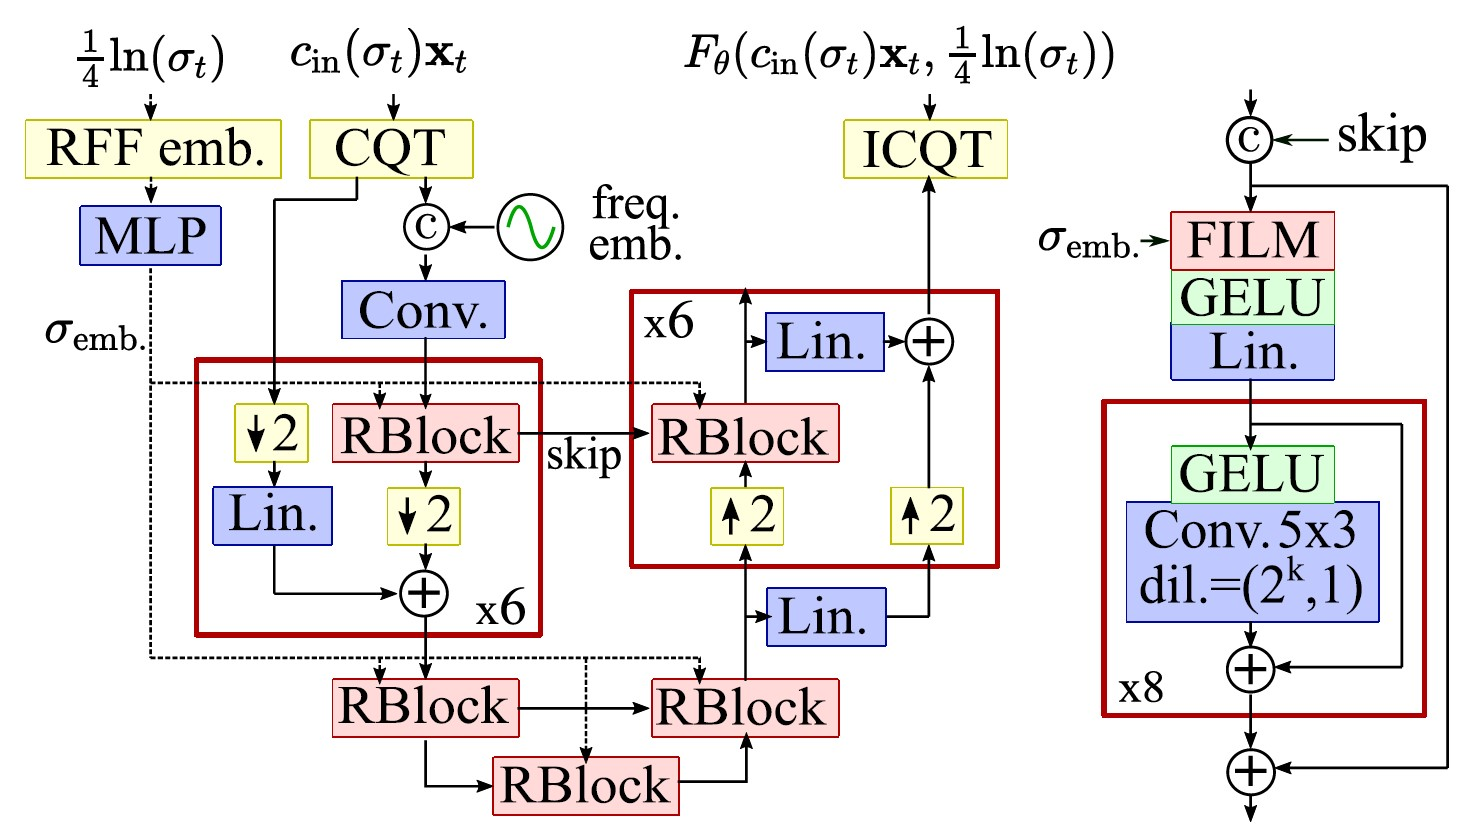

In [13]:
from IPython.display import Image
Image('/content/network.jpg')

# Model parameters

From Table 1 of [2], parameters used depending on the intrinsic noise of the signal and on the noise added for training

In [14]:
sigma_data = 0.057 # Default for MAESTRO dataset, it's changed when the dataset is loaded

def get_c_skip(sigma):
  return sigma_data**2 / (sigma**2 + sigma_data**2)

def get_c_out(sigma):
  return sigma * sigma_data / torch.sqrt(sigma**2 + sigma_data**2)

def get_c_in(sigma):
  return torch.sqrt(sigma**2 + sigma_data**2)**-1

def get_c_noise(sigma):
  return 1/4 * torch.log(sigma)

From equation 6 of [1] - generation of the random noise

In [15]:
sigma_min = 1e-6
sigma_max = 0.05 #10
ro = 10

def get_sigma(size):
  i = np.random.uniform(size=size)
  t = ( sigma_max**(1/ro) + i * (sigma_min**(1/ro) - sigma_max**(1/ro)) )**ro
  return t

# Loading the dataset

MAESTRO dataset size is 120GB, I think it's not a good idea to load it here, so I'll use some small audio files.

Moreover, a fair training time according to [1] is of about three days with 80GB of GPU RAM, that isn't feasible with Colab

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [17]:
! apt install librosa
! apt-get install ffmpeg # Needed for mp3 files

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package librosa
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Network hyper-parameters, heavily constrained by Colab restrictions

In [18]:
samplerate = 11025
seg_length = 10 # Length of inputs in seconds

reduction = 2 # Reduces sample length and adds samples
batch_size = 4  # Greater than 4 will exceed 15GB of GPU memory
train_size = 3/4

args = DotMap()
args.sample_rate = samplerate  # I keep it low due to RAM resources reasons, it should be 22050
args.cqt.numocts = 7
args.cqt.binsoct = 64
args.audio_len = int(seg_length * samplerate / reduction)
args.depth = 3   # Default: 6, but more than 3 will result in a cuda out of memory
args.r_depth = 1 # Default: 8, but more than 2 will result in a cuda out of memory

A bit slow, ensure that it runs only once per runtime.

Note that if the runtime is rebooted (but not disconnected) this step doesn't need to run again.

So, COMPUTE_DATASET is True only if it's the first run of the runtime.

It cuts the mp3 files in the 'dataset' directory into segments of seg_length sampled at samplerate.

This allows an easy access to the dataset, permitting to add mp3 files of whichever length and sample rate.

In [19]:
if COMPUTE_DATASET: # Compute dataset only if needed

  import numpy as np
  import librosa
  import soundfile as sf

  import os
  from os import listdir

  ds_path = '/content/dataset/'

  last = 0

  files = listdir(ds_path)

  for i, source in enumerate(files):
      data, samplerate = librosa.load(ds_path + source, sr = samplerate)

      length = len(data) / samplerate

      for j in range(int(length / seg_length)):
          seg = data[j*seg_length*samplerate : (j+1)*seg_length*samplerate]
          sf.write(ds_path + str(last + j) + ".wav", data = seg, samplerate = samplerate)

      last += j + 1

      print("Done %d/%d (%s)" %(i+1, len(files), str(source)))
      os.remove(ds_path + source)

Loading the dataset into train and test tensors

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from os import listdir
import soundfile as sf

import IPython
from IPython.display import Audio

ds_path = '/content/dataset/'

Xlist = []
files = listdir(ds_path)
last = len(files)

for i, f in enumerate(files):
  data, samplerate = sf.read(ds_path + f)
  if len(data.shape)>1:
    data = np.mean(data,axis=1)
  Xlist.append(data)

sigma_data = np.sqrt(np.mean(np.var(np.array(Xlist), axis=1)))
print("Sigma data: ", sigma_data)

X = torch.tensor(np.array(Xlist)).type(torch.float32).to(device)
X = torch.reshape(X, (X.shape[0] *reduction, -1))

X_train, X_test = train_test_split(X, test_size = 1- train_size, random_state = 108)

train_ds = TensorDataset(X_train)
test_ds = TensorDataset(X_test)

print("Random sample")
IPython.display.display(Audio(X[np.random.randint(0, last * reduction * train_size)].cpu(), rate = samplerate))

Sigma data:  0.12042220537565698
Random sample


Building the model

In [21]:
weights_path = '/content/weights_' 
# I encode in the ending numbers the depth of Encoder and R-Blocks
weights_path += str(args.depth) + str(args.r_depth) + '.h'

model = MainNet(args, device).to(device)

print('Number of parameters: %d' %len(list(model.parameters()))) # Are we sure?
#summary(model, [(1, args.audio_len), (1,1)])

/content/src/nsgt/nsgfwin_sl.py:66: UserWarning: Q-factor too high for frequencies 43.07,43.54,44.01,44.49,44.98,45.47,45.96,46.47,46.97,47.49,48.00,48.53,49.06,49.59,50.13,50.68,51.23,51.79,52.36,52.93,53.51,54.09,54.68,55.28,55.88,56.49,57.11,57.73,58.36,59.00,59.64,60.29,60.95,61.62,62.29,62.97,63.66,64.35,65.05,65.76,66.48,67.21,67.94,68.68,69.43,70.19,70.96,71.73,72.51,73.30
  warn("Q-factor too high for frequencies %s"%",".join("%.2f"%fi for fi in f[q >= qneeded]))


Number of parameters: 68


# Training

In [22]:
TRAIN = False # For easy "Run all" after reboot

Load weights if the network has been already trained

In [23]:
if not TRAIN:
  model.load_state_dict(torch.load(weights_path))

Otherwise, the network is trained (about 12 minutes per epoch)

In [50]:
if TRAIN:
  lossFunction = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 2e-4)

  epochs = 3
  iterations = int(reduction * last * train_size / batch_size)
  print("Total iterations per epoch: ", iterations)

  losses = []
  accuracies = []
  accuracies_training = []

  for e in range(epochs):
    train_loader = iter(DataLoader(train_ds, batch_size=batch_size, shuffle=True))
    print("Epoch: ", e+1)
    for t in range(iterations):

      audio = next(train_loader)[0].to(device)

      N, T = audio.shape
      device = audio.device

      # Sample a random batch of noise levels
      sigma = get_sigma(N)
      sigma = torch.Tensor(sigma).to(device)
      sigma = sigma.unsqueeze(-1)

      c_skip = get_c_skip(sigma)
      c_in = get_c_in(sigma)
      c_out = get_c_out(sigma)
      c_noise = get_c_noise(sigma)

      noise = torch.randn_like(audio) * sigma

      # Forward pass: Compute the prediction
      estimate = model(c_in * (audio + noise), c_noise)

      # Compute the target according to Karras paper [2]
      target = 1/c_out * (audio - c_skip * (audio + noise))

      # Compute loss
      loss = lossFunction(estimate, target) 

      # Zero gradients, perform a backward pass, and update the weights.
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())

      if t % int(iterations / 4) == 0:
          print(f'Done %3d steps - Loss: %f ' %(t+1, loss.item()))

Total iterations per epoch:  413
Epoch:  1
Done   1 steps - Loss: 0.761397 
Done 104 steps - Loss: 0.340230 
Done 207 steps - Loss: 0.854235 
Done 310 steps - Loss: 0.754705 
Done 413 steps - Loss: 0.721242 
Epoch:  2
Done   1 steps - Loss: 0.958259 
Done 104 steps - Loss: 0.602723 
Done 207 steps - Loss: 0.663984 
Done 310 steps - Loss: 0.928058 
Done 413 steps - Loss: 0.561102 
Epoch:  3
Done   1 steps - Loss: 0.538528 
Done 104 steps - Loss: 0.451089 
Done 207 steps - Loss: 0.346017 
Done 310 steps - Loss: 0.520496 
Done 413 steps - Loss: 0.762178 


Save weights to avoid future training

In [51]:
if TRAIN:
  torch.save(model.state_dict(), weights_path)

Clearly this can run only if the model has been trained in this runtime

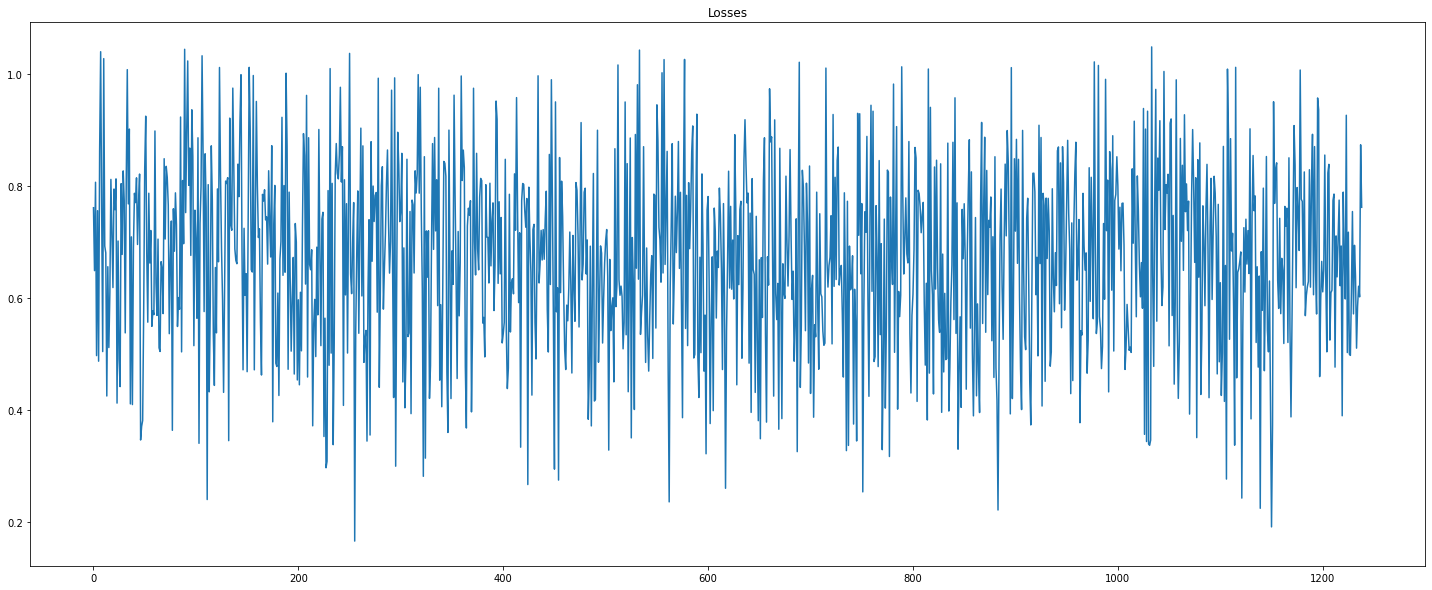

In [52]:
if TRAIN:
  import matplotlib.pyplot as plt
  plt.gcf().set_size_inches(25, 10)
  plt.title('Losses')
  plt.plot(losses)

# Evaluation

Loading a batch from the test set and generating the noise

In [72]:
test_loader = iter(DataLoader(test_ds, batch_size=batch_size, shuffle=True))
audio = next(test_loader)[0].to(device)

N, T = audio.shape
device = audio.device

# Sample a random batch of noise levels
sigma = get_sigma(N)
sigma = torch.Tensor(sigma).to(device)
sigma = sigma.unsqueeze(-1)

c_in = get_c_in(sigma)
c_out = get_c_out(sigma)
c_noise = get_c_noise(sigma)
c_skip = get_c_skip(sigma)

Denoising

I take a batch of audio signals and I add the noise to test the network.

In [73]:
noise = torch.randn_like(audio) * sigma

input = audio + noise

rnd = np.random.randint(0, batch_size)

with torch.no_grad(): # In this way GPU RAM is preserved
  output = model(c_in * input, c_noise)

Audio output

The network input and output are combined to obtain the result, according to paper [1], eq. 5

In [74]:
print("Audio:")
IPython.display.display(Audio(audio[rnd].cpu(), rate = samplerate))

print("Input:")
IPython.display.display(Audio(input[rnd].cpu(), rate = samplerate))

print("Output:")
IPython.display.display(Audio(output[rnd].detach().cpu(), rate = samplerate))

print("Result:")
result = c_skip * input[rnd] + c_out * output[rnd]
IPython.display.display(Audio(result.detach().cpu(), rate = samplerate))

Audio:


Input:


Output:


Result:


CQT and FT spectri output

In most cases can be seen how the network in fact is working well. It's job, in the spectrum domain, is to make the "Result" spectrogram similar to the "Audio" spectrogram given the "Input" one.

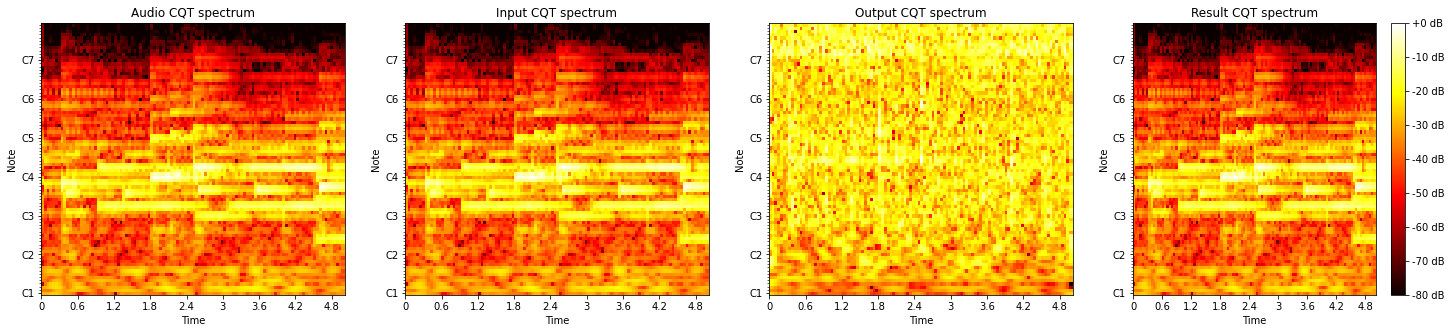

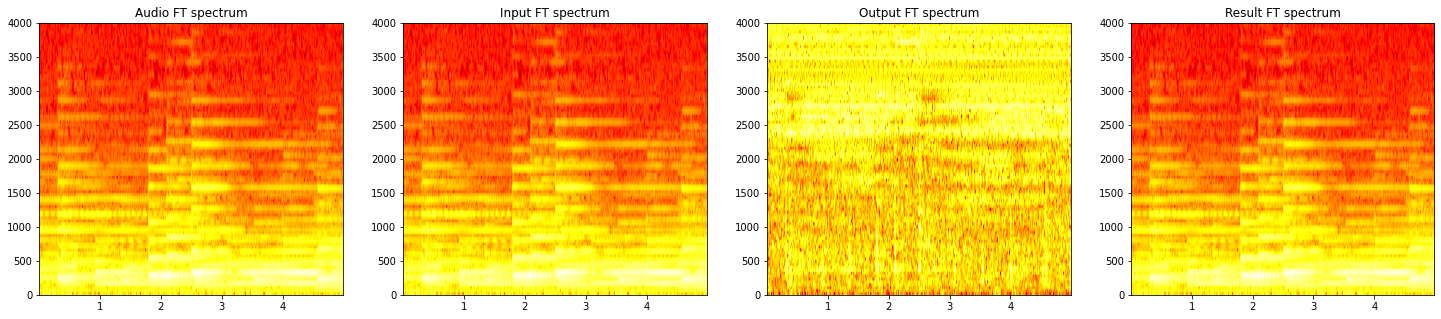

In [75]:
import matplotlib.pyplot as plt
import librosa.display

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)

C = np.abs(librosa.cqt(audio[rnd].cpu().numpy(), sr=samplerate))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=samplerate, x_axis='time', y_axis='cqt_note', ax=ax[0], cmap = "hot")
ax[0].set_title('Audio CQT spectrum')

C = np.abs(librosa.cqt(input[rnd].cpu().numpy(), sr=samplerate))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=samplerate, x_axis='time', y_axis='cqt_note', ax=ax[1], cmap = "hot")
ax[1].set_title('Input CQT spectrum')

C = np.abs(librosa.cqt(output[rnd].cpu().numpy(), sr=samplerate))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=samplerate, x_axis='time', y_axis='cqt_note', ax=ax[2], cmap = "hot")
ax[2].set_title('Output CQT spectrum')

C = np.abs(librosa.cqt(result[rnd].cpu().numpy(), sr=samplerate))
img = librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max),
                               sr=samplerate, x_axis='time', y_axis='cqt_note', ax=ax[3], cmap = "hot")
ax[3].set_title('Result CQT spectrum')
fig.colorbar(img, ax=ax[3], format="%+2.0f dB", cmap = "hot")

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)

plt.subplot(141)
plt.title("Audio FT spectrum")
plt.specgram(audio[rnd].cpu(), Fs=samplerate, cmap="hot", scale = "dB")
plt.axis(ymin=0, ymax=4000)

plt.subplot(142)
plt.title("Input FT spectrum")
plt.specgram(input[rnd].cpu(), Fs=samplerate, cmap="hot", scale = "dB")
plt.axis(ymin=0, ymax=4000)

plt.subplot(143)
plt.title("Output FT spectrum")
plt.specgram(output[rnd].cpu(), Fs=samplerate, cmap="hot", scale = "dB")
plt.axis(ymin=0, ymax=4000)

plt.subplot(144)
plt.title("Result FT spectrum")
plt.specgram(result[rnd].cpu(), Fs=samplerate, cmap="hot", scale = "dB")
plt.axis(ymin=0, ymax=4000)
plt.show();

# References

[1] E. Moliner, J. Lehtinen, V. Välimäki, "Solving audio inverse problems with a diffusion model"

[2] T. Karras, M. Aittala, T. Aila, and S. Laine, “Elucidating the design space of diffusion-based generative models,” in *Proc. NeurIPS*, Dec. 2022.